In [ ]:
#pip install tensorflow numpy pandas matplotlib seaborn warnings pandas-profiling==2.8.0 category_encoders sklearn lightgbm xgboost catboost mlxtend statsmodels

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Poner path de la carpeta o directorio donde está el set de datos

path = '...'

In [ ]:
# Carga de datasets

oil = pd.read_csv(path+"oil.csv",parse_dates = ['date'], index_col=['date'], infer_datetime_format=True)
holidays = pd.read_csv(path+"holidays_events.csv",parse_dates = ['date'], infer_datetime_format=True)
stores = pd.read_csv(path+"stores.csv")
test = pd.read_csv(path + 'test.csv',usecols=['store_nbr', 'family', 'date'],dtype={'store_nbr': 'float64', 'family': 'category'},parse_dates=['date'], infer_datetime_format=True)
train = pd.read_csv(path + 'train.csv',usecols=['store_nbr', 'family', 'date', 'sales'],dtype={'store_nbr': 'float64', 'family': 'category', 'sales': 'float32'},parse_dates=['date'], infer_datetime_format=True)
transactions = pd.read_csv(path+"transactions.csv",parse_dates = ['date'], infer_datetime_format=True)

In [ ]:
import random
import os

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 2022
seed_everything(SEED)

### PRUEBA


In [ ]:
# Ver perfilado completo de los datos

from pandas_profiling import ProfileReport
df_profile = ProfileReport(train, title="Profiling Report", progress_bar=True)
profile_html = df_profile.to_html()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from IPython.display import display, HTML
display(HTML(profile_html))

Number of variables,4
Number of observations,3000888
Missing cells,0
Missing cells (%),0.0%
Duplicate rows,0
Duplicate rows (%),0.0%
Total size in memory,60.1 MiB
Average record size in memory,21.0 B
DateTime,1
Numeric,2
Categorical,1


ANÁLISIS DE DATASET OIL

In [ ]:
#Ver primeras líneas de oil

oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [ ]:
display(oil)

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20
...,...
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46


In [ ]:
# Cantidad de valores nulos tenemos

oil.isna().sum().sort_values(ascending=False).head()

dcoilwtico    43
dtype: int64

In [ ]:
# Vamos a ver como esos NaN en la primera aproximación los vamos a quitar con una interpolación lineal. 
# Posteriormente se verá si alguno de los datos  por falta de datos reales (cierre de mercados....)

oil['dcoilwtico'].interpolate(method='linear', inplace=True, limit_direction='both')

In [ ]:
# Cantidad de valores nulos después de la interpolación

oil.isna().sum().sort_values(ascending=False).head()

dcoilwtico    0
dtype: int64

In [ ]:
# Imputamos el dataframe rellenando días si hay alguno que no existía, con los valores del día siguiente

oil=pd.DataFrame(oil.resample('D').bfill())

In [ ]:
display(oil)

,dcoilwtico
date,
2013-01-01,93.14
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-05,93.20
...,...
2017-08-27,46.40
2017-08-28,46.40
2017-08-29,46.46


In [ ]:
oil.isna().sum().sort_values(ascending=False).head()

dcoilwtico    0
dtype: int64

array([[<AxesSubplot:title={'center':'dcoilwtico'}>]], dtype=object)

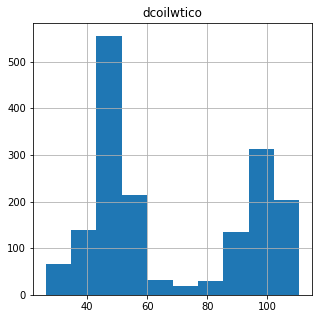

In [ ]:
# Hacemos un histograma

oil.hist(figsize=(5, 5))

#vemos que las cantidas son variadas

ANALIZAMOS EL DATASET DE TEST Y DEJAMOS POR ESCRITO LA UNIÓN DE TEST Y OIL POR COLUMNAS DE "date"

SIEMPRE UTILIZAREMOS DATASETS NUEVOS SIN PISAR LOS ORIGINALES

In [ ]:
# pequeño muestremo de train

display(train)

,date,store_nbr,family,sales
0,2013-01-01,1.0,AUTOMOTIVE,0.000000
1,2013-01-01,1.0,BABY CARE,0.000000
2,2013-01-01,1.0,BEAUTY,0.000000
3,2013-01-01,1.0,BEVERAGES,0.000000
4,2013-01-01,1.0,BOOKS,0.000000
...,...,...,...,...
3000883,2017-08-15,9.0,POULTRY,438.132996
3000884,2017-08-15,9.0,PREPARED FOODS,154.552994
3000885,2017-08-15,9.0,PRODUCE,2419.729004
3000886,2017-08-15,9.0,SCHOOL AND OFFICE SUPPLIES,121.000000


In [ ]:
# Unión de train y oil por la columna común de "date"

trainfinal = pd.merge(train, oil, how='left', on="date")

In [ ]:
# Vemos como quedan los dos datasets unidos

display(trainfinal)

,date,store_nbr,family,sales,dcoilwtico
0,2013-01-01,1.0,AUTOMOTIVE,0.000000,93.14
1,2013-01-01,1.0,BABY CARE,0.000000,93.14
2,2013-01-01,1.0,BEAUTY,0.000000,93.14
3,2013-01-01,1.0,BEVERAGES,0.000000,93.14
4,2013-01-01,1.0,BOOKS,0.000000,93.14
...,...,...,...,...,...
3000883,2017-08-15,9.0,POULTRY,438.132996,47.57
3000884,2017-08-15,9.0,PREPARED FOODS,154.552994,47.57
3000885,2017-08-15,9.0,PRODUCE,2419.729004,47.57
3000886,2017-08-15,9.0,SCHOOL AND OFFICE SUPPLIES,121.000000,47.57


In [ ]:
# Vemos los valores nulos en el dataset de trainfinal, no habiendo ninguno

trainfinal.isna().sum().sort_values(ascending=False).head()

date          0
store_nbr     0
family        0
sales         0
dcoilwtico    0
dtype: int64

ANALIZAMOS DATASET STORES

In [ ]:
# Podemos ver que las tiendas tienen código de tienda, ciudad, estado un tipo y cluster (que es agrupación de tiendas similares)

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
# Analizamos valores nulos en dataset y vemos la inexistencia de los mismo

stores.isna().sum().sort_values(ascending=False).head()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [ ]:
# Valores distintos que tiene la columna 'state' del dataset de stores

stores['state'].unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

ANALIZAMOS DATASET HOLIDAYS

In [ ]:
# Pequeña muestra de holidays

holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
# Corrección de un día no estaba bien

holidays['date'] = holidays['date'].replace({'2013-04-29': pd.to_datetime('2013-03-29')})

In [ ]:
# Cantidad de valores únicos existen en columna 'locale_name' del dataset holidays

holidays['locale_name'].unique()

array(['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo',
       'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo',
       'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato',
       'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas',
       'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil'],
      dtype=object)

In [ ]:
#  Quitamos los work days y los transferidos = True porque no son días festivos

holidays = holidays.loc[holidays['type'] != "Work Day"]
holidays  = holidays.loc[holidays['transferred'] == False].drop('transferred', axis = 1)

In [ ]:
holidays.head()

,date,type,locale,locale_name,description
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba


In [ ]:
# Creamos un datset final con todos los días que es festivo y por cada uno de ellos ñas tiendas en la que no se ha abierto

def holidays_stores(holiday_locale, holiday_locale_name):
    if holiday_locale == 'National':
        return stores['store_nbr'].unique()
    elif holiday_locale == 'Local':
        return stores['store_nbr'].loc[stores['city'] == holiday_locale_name].to_numpy()
    elif holiday_locale == 'Regional':
        return stores['store_nbr'].loc[stores['state'] == holiday_locale_name].to_numpy()
    else:
        return []


holidays['cities'] = holidays.apply(lambda x : holidays_stores(x['locale'],x['locale_name']), axis = 1)

holidays = holidays.drop(columns = ['type','locale','locale_name','description'], axis = 0)

cities_dummies = pd.get_dummies(holidays['cities'].explode()).sum(level=0)
holidays_with_dummies = pd.concat([holidays, cities_dummies], axis = 1).drop(['cities'], axis = 1)

holidays_aux = pd.melt(holidays_with_dummies, id_vars = 'date', var_name = 'store_nbr').drop(['value'], axis = 1)
holidays_by_store = holidays_aux.groupby(['date','store_nbr']).sum().reset_index()

In [ ]:
# Vemos si se ha creamos bien el dataset anteriormente hecho (holidays_by_store)

holidays_by_store.head()

,date,store_nbr
0,2012-03-02,1
1,2012-03-02,2
2,2012-03-02,3
3,2012-03-02,4
4,2012-03-02,5


HACER DATASET FINAL

In [ ]:
# Comenzamos haciendo una nueva columna 'holiday' en el dataset anterior definifiniendo como True

holidays_by_store['holiday']=True

In [ ]:
holidays_by_store.head()

,date,store_nbr,holiday
0,2012-03-02,1,True
1,2012-03-02,2,True
2,2012-03-02,3,True
3,2012-03-02,4,True
4,2012-03-02,5,True


In [ ]:
# Unimos datasets

trainfinal2 = pd.merge(trainfinal, holidays_by_store, how='left', on=['store_nbr','date'])

In [ ]:
trainfinal2.head()

,date,store_nbr,family,sales,dcoilwtico,holiday
0,2013-01-01,1.0,AUTOMOTIVE,0.0,93.14,True
1,2013-01-01,1.0,BABY CARE,0.0,93.14,True
2,2013-01-01,1.0,BEAUTY,0.0,93.14,True
3,2013-01-01,1.0,BEVERAGES,0.0,93.14,True
4,2013-01-01,1.0,BOOKS,0.0,93.14,True


In [ ]:
# Los valores nulos que encontramos, corresponden a la columna holiday anteriormente hecha y son todos los valores que deberían ser False, puesto que no son días con "holiday"

trainfinal2.isna().sum().sort_values(ascending=False).head()

holiday      2574990
date               0
store_nbr          0
family             0
sales              0
dtype: int64

In [ ]:
# Rellenamos los valores nulos con False

trainfinal2['holiday']=trainfinal2['holiday'].fillna(value=False)

In [ ]:
trainfinal2.isna().sum().sort_values(ascending=False)

date          0
store_nbr     0
family        0
sales         0
dcoilwtico    0
holiday       0
dtype: int64

In [ ]:
trainfinal2.head()

,date,store_nbr,family,sales,dcoilwtico,holiday
0,2013-01-01,1.0,AUTOMOTIVE,0.0,93.14,True
1,2013-01-01,1.0,BABY CARE,0.0,93.14,True
2,2013-01-01,1.0,BEAUTY,0.0,93.14,True
3,2013-01-01,1.0,BEVERAGES,0.0,93.14,True
4,2013-01-01,1.0,BOOKS,0.0,93.14,True


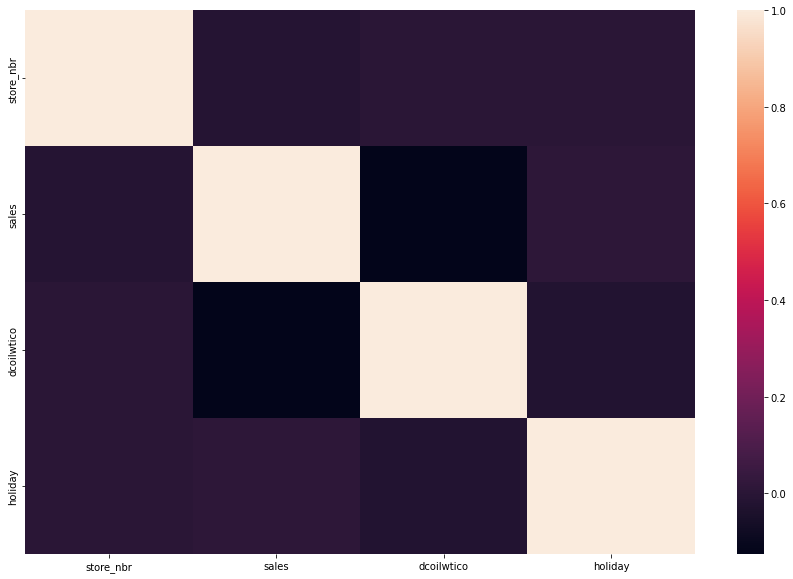

In [ ]:
# Correlaciones de con seaborn

fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.heatmap(trainfinal2.corr(method='kendall'), ax=ax);

# Nos encontramos que las ventas tienen relación con holiday y store_nbr, pero no tanto con el precio del oil

In [ ]:
# Analizamos el dataset transactions

display(transactions)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [ ]:
#Vemos si tenemos algún valor nulo

transactions.isna().sum().sort_values(ascending=False).head()

date            0
store_nbr       0
transactions    0
dtype: int64

In [ ]:
# Unimos datasets

trainfinal2 = pd.merge(trainfinal2,transactions, how='left', on=['store_nbr','date'])

In [ ]:
# Transmitir una frecuencia de día

trainfinal2.date = trainfinal2.date.dt.to_period('D')

In [ ]:
display(trainfinal2)

,date,store_nbr,family,sales,dcoilwtico,holiday,transactions
0,2013-01-01,1.0,AUTOMOTIVE,0.000000,93.14,True,NaN
1,2013-01-01,1.0,BABY CARE,0.000000,93.14,True,NaN
2,2013-01-01,1.0,BEAUTY,0.000000,93.14,True,NaN
3,2013-01-01,1.0,BEVERAGES,0.000000,93.14,True,NaN
4,2013-01-01,1.0,BOOKS,0.000000,93.14,True,NaN
...,...,...,...,...,...,...,...
3000883,2017-08-15,9.0,POULTRY,438.132996,47.57,True,2155.0
3000884,2017-08-15,9.0,PREPARED FOODS,154.552994,47.57,True,2155.0
3000885,2017-08-15,9.0,PRODUCE,2419.729004,47.57,True,2155.0
3000886,2017-08-15,9.0,SCHOOL AND OFFICE SUPPLIES,121.000000,47.57,True,2155.0


In [ ]:
# Como al final no se van a utilizar las columnas 'dcoilwtico','holiday','transactions' porque es un primer modelo, se quitan para evitar problemas futuros.
# Sino se tendría que hacer una limpieza de los valores nulos de transactions

In [ ]:
# Quitamos columnas para de cara al modelo sea sencillo

trainfinal2 = trainfinal2.drop(columns = ['dcoilwtico','holiday','transactions'], axis = 0)

In [ ]:
# Ponemos índices varias columnas para realizar bien stack/unstack

trainfinal2 = trainfinal2.set_index(['store_nbr', 'family', 'date']).sort_index()

### MODELO

In [ ]:
# Fechas entre las que hacemos el modelo, vimos en varios notebooks y hemos comprobado con otros valores que entre estos valores eran con los que salían los mejores resultados

sdate = '2017-04-01'
edate = '2017-08-15'

In [ ]:
# Cambiamos la forma de organizar nuestra tabla

y = trainfinal2.unstack(['store_nbr','family']).loc[sdate:edate]

In [ ]:
# Formación de modelo. Utilizamos el proceso de Fourier para que nos adapte lo mauyor porsible las funciones a frecuencia de semanas
# Con DeterministicProcess se quiere que no haya valores aleatorios y que los valores a futuro son predecibles al 100% con los que damos.

fourier = CalendarFourier(freq='W', order=4)

dp = DeterministicProcess(index=y.index, 
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)

X = dp.in_sample()


# Modelo Ridge da buenos resultados con esos valores, en comparación con otros algoritmos probados con hiperparametrización pobre

model = Ridge(fit_intercept=True, solver='auto', alpha=0.4, normalize=True, random_state=SEED)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [ ]:
# Ver como queda el dataset de predicción

display(y_pred)

sales                                                          \
store_nbr        1.0                                                            
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-04-01   4.943877       0.0  3.029341  2380.681353  0.315531   391.771008   
2017-04-02   2.682919       0.0  1.846651  1396.069345  0.387319   233.611859   
2017-04-03   4.189108       0.0  3.067403  2259.880703  0.494033   390.087062   
2017-04-04   3.977553       0.0  2.929571  2326.515278  0.529379   380.082222   
2017-04-05   3.985138       0.0  3.147418  2401.167154  0.723972   414.013938   
...               ...       ...       ...          ...       ...          ...   
2017-08-11   5.848141       0.0  3.038468  2218.912570  0.181571   339.810136   
2017-08-12   5.215531       0.0  4.009864  2338.636700  0.019442   356.212915   
2017-08-13   2.954573       0.0  2.827173  1354.024692  0.091231   198.053766   
2017-08-14   4.460762       0.0  4.047926  2217.836050  0.197944   354.528969   
2017-08-15   4.249207       0.0  3.910093  2284.470625  0.233290   344.524129   

                                                            ...            \
store_nbr                                                   ...      54.0   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-04-01   14.219203  649.299493  802.822317  145.135580  ...  1.568224   
2017-04-02    8.111124  372.888080  491.577237   90.565474  ...  1.030200   
2017-04-03   15.895165  676.573782  775.884810  146.015801  ...  0.885641   
2017-04-04   17.441363  746.649776  760.592781  142.255155  ...  0.815249   
2017-04-05   16.781404  817.774250  856.106414  148.327921  ...  0.960190   
...                ...         ...         ...         ...  ...       ...   
2017-08-11   19.191740  686.383188  704.185291  147.000755  ...  1.008934   
2017-08-12   12.278909  619.466061  714.674686  134.419079  ...  1.658596   
2017-08-13    6.170830  343.054648  403.429606   79.848973  ...  1.120571   
2017-08-14   13.954871  646.740350  687.737179  135.299300  ...  0.976013   
2017-08-15   15.501070  716.816344  672.445150  131.538654  ...  0.905621   

                                                                          \
store_nbr                                                                  
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                       
2017-04-01  56.405806    239.189403     0.138147                4.820544   
2017-04-02  59.297457    301.504814     0.102243                4.781534   
2017-04-03  56.253124    227.016016     0.102197                3.844640   
2017-04-04  51.089408    215.020552     0.066326                3.947611   
2017-04-05  44.170776    185.112048     0.068642                3.545844   
...               ...           ...          ...                     ...   
2017-08-11  53.693640    148.217246     0.140129                2.940936   
2017-08-12  60.367239    205.673243     0.134926                3.129020   
2017-08-13  63.258890    267.988653     0.099022                3.090010   
2017-08-14  60.214557    193.499856     0.098976                2.153116   
2017-08-15  55.050841    181.504391     0.063105                2.256087   

                                                                             \
store_nbr                                                                     
family        POULTRY PREPARED FOODS     PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                          
2017-04-01  61.606022      68.942671  727.861608                   9.505074   
2017-04-02  69.058744      97.293493  807.442335                  10.957613   
2017-04-03  53.723893      80

In [ ]:
# Resultados en la parte de entrenamiento

y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()

y_target['sales_pred'] = y_pred['sales'].clip(0.) # Sales should be >= 0

y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

#Tenemos para cada familia el error mean_squared_log_error comparando la predicción y las ventas reales. El mayor error está en la familia SCHOOL AND OFFICE SUPPLIES

family
AUTOMOTIVE                    0.275359
BABY CARE                     0.069143
BEAUTY                        0.287197
BEVERAGES                     0.207363
BOOKS                         0.028114
BREAD/BAKERY                  0.130952
CELEBRATION                   0.312107
CLEANING                      0.212916
DAIRY                         0.142760
DELI                          0.114984
EGGS                          0.154761
FROZEN FOODS                  0.157840
GROCERY I                     0.216242
GROCERY II                    0.374713
HARDWARE                      0.284895
HOME AND KITCHEN I            0.276790
HOME AND KITCHEN II           0.228813
HOME APPLIANCES               0.161462
HOME CARE                     0.129439
LADIESWEAR                    0.280453
LAWN AND GARDEN               0.272637
LINGERIE                      0.420421
LIQUOR,WINE,BEER              0.645422
MAGAZINES                     0.269079
MEATS                         0.130259
PERSONAL CARE     

<AxesSubplot:xlabel='date'>

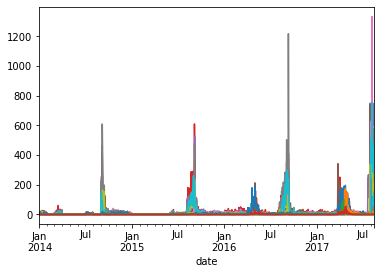

In [ ]:
#Ploteamos los resultados de las ventas predecidas, según la tienda y una familia

trainfinal2.unstack(['store_nbr', 'family']).loc['2014':].loc(axis=1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES'].plot(legend=None)

<AxesSubplot:xlabel='date'>

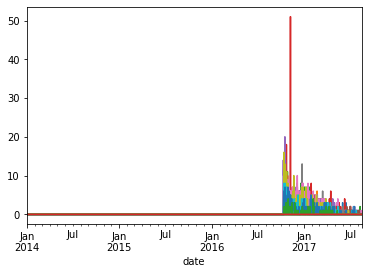

In [ ]:
trainfinal2.unstack(['store_nbr', 'family']).loc['2014':].loc(axis=1)['sales', :, 'BOOKS'].plot(legend=None)

In [ ]:
# Ponemos índices y los ordenamos

test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [ ]:
# Fechas entre las que tenemos que predecir según el archivo de test

stest = '2017-08-16'
etest = '2017-08-31'

In [ ]:
# Predicciones

X_test = dp.out_of_sample(steps=16)

sales_predic = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
sales_predic = sales_predic.stack(['store_nbr', 'family'])

sales_predic[sales_predic < 0] = 0. # Ventas deben ser >= 0

In [ ]:
# Submission

df_sub = pd.read_csv(path + 'sample_submission.csv', index_col='id')
df_sub.sales = sales_predic.values
df_sub.to_csv('submission.csv', index=True)

